HDP-base spell-sound analyzer
developed by Kow Kuroda (kow.kuroda@gmail.com)

History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装

In [679]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [680]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [681]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [682]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [683]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [684]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[1]
ngram_is_inclusive  = True
ngram_inclusiveness = 2

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
add_boundary        = True
boundary_mark       = "#"

## term setting
term_is_skippy      = False
n_for_ngram         = 4
max_gap_ratio       = 0.8
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")
## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
## check
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: sound
term_is_skippy: False
max_gap_size: 9
n_for_ngram: 4
accent_status: -unaccented
term_type: sn_4gram


In [685]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[4]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: en_A_only
target lang: English adj (WN) [en_A_only]
target_class: 


In [686]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
## The following value is crucial to prevent "Row sum not equal 1" error
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units
# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120
# saving output
save_LDAvis          = False
save_topic_structure = False

In [687]:
## sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 5000
second_sampling          = False
second_sampling_rate     = 0.7

In [688]:
## set target files
import glob
data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 '

In [689]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']
#
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/wn3/en_A_only.csv


,spell,sound
5276,tribal,ˈtɹaɪbəɫ
542,bankrupt,ˈbæŋkɹəpt
1310,cortical,ˈkɔɹtəkəɫ
3,abdominal,æbˈdɑmənəɫ
3362,messy,ˈmɛsi
3143,lengthwise,ˈɫɛŋθˌwaɪz
4389,rehabilitative,ˌɹiəˈbɪɫəˌteɪtɪv
2033,expedient,ɪkˈspidiənt
1876,ellipsoid,ɪˈɫɪpsɔɪd
1260,contracted,ˈkɑntɹæktəd


In [690]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if add_boundary:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                spell          sound
1766         #driven#       #dɹɪvən#
5008    #subservient#   #səbsɝviənt#
1213     #consensual#   #kənsɛnsuəɫ#
3002  #irrepressible#  #ɪɹəpɹɛsəbəɫ#
5818           #well#          #wɛɫ#
...               ...            ...
753          #boyish#        #bɔɪɪʃ#
664      #bituminous#    #bɪtumənəs#
4271    #questioning#   #kwɛstʃənɪŋ#
4421       #reported#     #ɹipɔɹtɪd#
1838      #educative#   #ɛdʒɪkeɪtɪv#

[5000 rows x 2 columns]


In [691]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
1766,#driven#,#dɹɪvən#,"[#, d, r, i, v, e, n, #]",8,0,0,"[#, d, ɹ, ɪ, v, ə, n, #]",8
5008,#subservient#,#səbsɝviənt#,"[#, s, u, b, s, e, r, v, i, e, n, t, #]",13,0,0,"[#, s, ə, b, s, ɝ, v, i, ə, n, t, #]",12
1213,#consensual#,#kənsɛnsuəɫ#,"[#, c, o, n, s, e, n, s, u, a, l, #]",12,0,0,"[#, k, ə, n, s, ɛ, n, s, u, ə, ɫ, #]",12
3002,#irrepressible#,#ɪɹəpɹɛsəbəɫ#,"[#, i, r, r, e, p, r, e, s, s, i, b, l, e, #]",15,0,0,"[#, ɪ, ɹ, ə, p, ɹ, ɛ, s, ə, b, ə, ɫ, #]",13
5818,#well#,#wɛɫ#,"[#, w, e, l, l, #]",6,0,0,"[#, w, ɛ, ɫ, #]",5
...,...,...,...,...,...,...,...,...
753,#boyish#,#bɔɪɪʃ#,"[#, b, o, y, i, s, h, #]",8,0,0,"[#, b, ɔ, ɪ, ɪ, ʃ, #]",7
664,#bituminous#,#bɪtumənəs#,"[#, b, i, t, u, m, i, n, o, u, s, #]",12,0,0,"[#, b, ɪ, t, u, m, ə, n, ə, s, #]",11
4271,#questioning#,#kwɛstʃənɪŋ#,"[#, q, u, e, s, t, i, o, n, i, n, g, #]",13,0,0,"[#, k, w, ɛ, s, t, ʃ, ə, n, ɪ, ŋ, #]",12
4421,#reported#,#ɹipɔɹtɪd#,"[#, r, e, p, o, r, t, e, d, #]",10,0,0,"[#, ɹ, i, p, ɔ, ɹ, t, ɪ, d, #]",10


In [692]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sn_4gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
1766,#driven#,#dɹɪvən#,"[#, d, r, i, v, e, n, #]",8,0,0,"[#, d, ɹ, ɪ, v, ə, n, #]",8
5818,#well#,#wɛɫ#,"[#, w, e, l, l, #]",6,0,0,"[#, w, ɛ, ɫ, #]",5
4284,#racking#,#ɹækɪŋ#,"[#, r, a, c, k, i, n, g, #]",9,0,0,"[#, ɹ, æ, k, ɪ, ŋ, #]",7
2358,#girlish#,#ɡɝɫɪʃ#,"[#, g, i, r, l, i, s, h, #]",9,0,0,"[#, ɡ, ɝ, ɫ, ɪ, ʃ, #]",7
2725,#impressive#,#ɪmpɹɛsɪv#,"[#, i, m, p, r, e, s, s, i, v, e, #]",12,0,0,"[#, ɪ, m, p, ɹ, ɛ, s, ɪ, v, #]",10
...,...,...,...,...,...,...,...,...
4246,#purple#,#pɝpəɫ#,"[#, p, u, r, p, l, e, #]",8,0,0,"[#, p, ɝ, p, ə, ɫ, #]",7
2673,#immaculate#,#ɪmækjuɫɪt#,"[#, i, m, m, a, c, u, l, a, t, e, #]",12,0,0,"[#, ɪ, m, æ, k, j, u, ɫ, ɪ, t, #]",11
753,#boyish#,#bɔɪɪʃ#,"[#, b, o, y, i, s, h, #]",8,0,0,"[#, b, ɔ, ɪ, ɪ, ʃ, #]",7
664,#bituminous#,#bɪtumənəs#,"[#, b, i, t, u, m, i, n, o, u, s, #]",12,0,0,"[#, b, ɪ, t, u, m, ə, n, ə, s, #]",11


In [693]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

3761

In [694]:
## generic function for n-gram generation
def add_ngram_to_df(dfx, n_for_ngram: int, var_prefix: str = "", ngram_is_skippy: bool = False, ngram_is_inclusive: bool = ngram_is_inclusive, ngram_inclusiveness: int = ngram_inclusiveness, seg_joint: str = "", use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    inclusion_size = (n_for_ngram - ngram_inclusiveness)
    print(f"inclusion_size: {inclusion_size}")
    assert inclusion_size >= 0
    source_var = f"{var_prefix}1gram"
    print(f"source_var: {source_var}")
    unigrams = df[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if ngram_is_skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, check = False)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, check = False)] for x in unigrams ]
    else:
        import gen_ngrams
        if ngram_is_skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = "", check = False) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = "", check = False) for x in unigrams ]
    ## 包括的 2gramの生成
    if ngram_is_inclusive:
        assert (n_for_ngram - 1) > 0
        if ngram_is_skippy and n_for_ngram > 2:
            supplement_var = f"{var_prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{var_prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            included = [ x for x in list(dfx[supplement_var])[i] if len(x) >= inclusion_size ]
            if len(included) > 0:
                g.extend(included)
    ## 変数の追加
    if ngram_is_skippy:
        added_var = f"{var_prefix}skippy{n_for_ngram}gram"
    else:
        added_var = f"{var_prefix}{n_for_ngram}gram"
    print(f"added_var: {added_var}")
    dfx[added_var] = ngrams
    ## check result
    print(dfx[added_var])

# Spell

In [695]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, var_prefix = "sp_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 0
source_var: sp_1gram
supplement_var: sp_1gram
added_var: sp_2gram
1766    [#d, dr, ri, iv, ve, en, n#, #, d, r, i, v, e,...
5818               [#w, we, el, ll, l#, #, w, e, l, l, #]
4284    [#r, ra, ac, ck, ki, in, ng, g#, #, r, a, c, k...
2358    [#g, gi, ir, rl, li, is, sh, h#, #, g, i, r, l...
2725    [#i, im, mp, pr, re, es, ss, si, iv, ve, e#, #...
                              ...                        
4246    [#p, pu, ur, rp, pl, le, e#, #, p, u, r, p, l,...
2673    [#i, im, mm, ma, ac, cu, ul, la, at, te, e#, #...
753     [#b, bo, oy, yi, is, sh, h#, #, b, o, y, i, s,...
664     [#b, bi, it, tu, um, mi, in, no, ou, us, s#, #...
4421    [#r, re, ep, po, or, rt, te, ed, d#, #, r, e, ...
Name: sp_2gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [696]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, var_prefix = "sp_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 1
source_var: sp_1gram
supplement_var: sp_2gram
added_var: sp_3gram
1766    [#dr, dri, riv, ive, ven, en#, #d, dr, ri, iv,...
5818    [#we, wel, ell, ll#, #w, we, el, ll, l#, #, w,...
4284    [#ra, rac, ack, cki, kin, ing, ng#, #r, ra, ac...
2358    [#gi, gir, irl, rli, lis, ish, sh#, #g, gi, ir...
2725    [#im, imp, mpr, pre, res, ess, ssi, siv, ive, ...
                              ...                        
4246    [#pu, pur, urp, rpl, ple, le#, #p, pu, ur, rp,...
2673    [#im, imm, mma, mac, acu, cul, ula, lat, ate, ...
753     [#bo, boy, oyi, yis, ish, sh#, #b, bo, oy, yi,...
664     [#bi, bit, itu, tum, umi, min, ino, nou, ous, ...
4421    [#re, rep, epo, por, ort, rte, ted, ed#, #r, r...
Name: sp_3gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [697]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, var_prefix = "sp_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 2
source_var: sp_1gram
supplement_var: sp_3gram
added_var: sp_4gram
1766    [#dri, driv, rive, iven, ven#, #dr, dri, riv, ...
5818    [#wel, well, ell#, #we, wel, ell, ll#, #w, we,...
4284    [#rac, rack, acki, ckin, king, ing#, #ra, rac,...
2358    [#gir, girl, irli, rlis, lish, ish#, #gi, gir,...
2725    [#imp, impr, mpre, pres, ress, essi, ssiv, siv...
                              ...                        
4246    [#pur, purp, urpl, rple, ple#, #pu, pur, urp, ...
2673    [#imm, imma, mmac, macu, acul, cula, ulat, lat...
753     [#boy, boyi, oyis, yish, ish#, #bo, boy, oyi, ...
664     [#bit, bitu, itum, tumi, umin, mino, inou, nou...
4421    [#rep, repo, epor, port, orte, rted, ted#, #re...
Name: sp_4gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [698]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, var_prefix = "sp_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 3
source_var: sp_1gram
supplement_var: sp_4gram
added_var: sp_5gram
1766    [#driv, drive, riven, iven#, #dri, driv, rive,...
5818    [#well, well#, #wel, well, ell#, #we, wel, ell...
4284    [#rack, racki, ackin, cking, king#, #rac, rack...
2358    [#girl, girli, irlis, rlish, lish#, #gir, girl...
2725    [#impr, impre, mpres, press, ressi, essiv, ssi...
                              ...                        
4246    [#purp, purpl, urple, rple#, #pur, purp, urpl,...
2673    [#imma, immac, mmacu, macul, acula, culat, ula...
753     [#boyi, boyis, oyish, yish#, #boy, boyi, oyis,...
664     [#bitu, bitum, itumi, tumin, umino, minou, ino...
4421    [#repo, repor, eport, porte, orted, rted#, #re...
Name: sp_5gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [699]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, var_prefix = "sp_", ngram_is_skippy = True, ngram_is_inclusive = ngram_is_inclusive, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 0
source_var: sp_1gram
supplement_var: sp_1gram
added_var: sp_skippy2gram
1766    [#d, #…r, #…i, #…v, #…e, #…n, #…#, dr, d…i, d…...
5818    [#w, #…e, #…l, #…l, #…#, we, w…l, w…l, w…#, el...
4284    [#r, #…a, #…c, #…k, #…i, #…n, #…g, #…#, ra, r…...
2358    [#g, #…i, #…r, #…l, #…i, #…s, #…h, #…#, gi, g…...
2725    [#i, #…m, #…p, #…r, #…e, #…s, #…s, #…i, #…v, #...
                              ...                        
4246    [#p, #…u, #…r, #…p, #…l, #…e, #…#, pu, p…r, p…...
2673    [#i, #…m, #…m, #…a, #…c, #…u, #…l, #…a, #…t, #...
753     [#b, #…o, #…y, #…i, #…s, #…h, #…#, bo, b…y, b…...
664     [#b, #…i, #…t, #…u, #…m, #…i, #…n, #…o, #…u, #...
4421    [#r, #…e, #…p, #…o, #…r, #…t, #…e, #…d, #…#, r...
Name: sp_skippy2gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [700]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, var_prefix = "sp_", ngram_is_skippy = True, ngram_is_inclusive = ngram_is_inclusive, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 1
source_var: sp_1gram
supplement_var: sp_skippy2gram
added_var: sp_skippy3gram
1766    [#dr, #d…i, #d…v, #d…e, #d…n, #d…#, #…ri, #…r…...
5818    [#we, #w…l, #w…l, #w…#, #…el, #…e…l, #…e…#, #…...
4284    [#ra, #r…c, #r…k, #r…i, #r…n, #r…g, #r…#, #…ac...
2358    [#gi, #g…r, #g…l, #g…i, #g…s, #g…h, #g…#, #…ir...
2725    [#im, #i…p, #i…r, #i…e, #i…s, #i…s, #i…i, #i…v...
                              ...                        
4246    [#pu, #p…r, #p…p, #p…l, #p…e, #p…#, #…ur, #…u…...
2673    [#im, #i…m, #i…a, #i…c, #i…u, #i…l, #i…a, #i…t...
753     [#bo, #b…y, #b…i, #b…s, #b…h, #b…#, #…oy, #…o…...
664     [#bi, #b…t, #b…u, #b…m, #b…i, #b…n, #b…o, #b…u...
4421    [#re, #r…p, #r…o, #r…r, #r…t, #r…e, #r…d, #r…#...
Name: sp_skippy3gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [701]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, var_prefix = "sp_", ngram_is_skippy = True, ngram_is_inclusive = ngram_is_inclusive, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 2
source_var: sp_1gram
supplement_var: sp_skippy3gram
added_var: sp_skippy4gram
1766    [#dri, #dr…v, #dr…e, #dr…n, #dr…#, #d…iv, #d…i...
5818    [#wel, #we…l, #we…#, #w…ll, #w…l…#, #w…l#, #…e...
4284    [#rac, #ra…k, #ra…i, #ra…n, #ra…g, #ra…#, #r…c...
2358    [#gir, #gi…l, #gi…i, #gi…s, #gi…h, #gi…#, #g…r...
2725    [#imp, #im…r, #im…e, #im…s, #im…s, #im…i, #im…...
                              ...                        
4246    [#pur, #pu…p, #pu…l, #pu…e, #pu…#, #p…rp, #p…r...
2673    [#imm, #im…a, #im…c, #im…u, #im…l, #im…a, #im…...
753     [#boy, #bo…i, #bo…s, #bo…h, #bo…#, #b…yi, #b…y...
664     [#bit, #bi…u, #bi…m, #bi…i, #bi…n, #bi…o, #bi…...
4421    [#rep, #re…o, #re…r, #re…t, #re…e, #re…d, #re…...
Name: sp_skippy4gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [702]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, var_prefix = "sp_", ngram_is_skippy = True, ngram_is_inclusive = ngram_is_inclusive, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 3
source_var: sp_1gram
supplement_var: sp_skippy4gram
added_var: sp_skippy5gram
1766    [#driv, #dri…e, #dri…n, #dri…#, #dr…ve, #dr…v…...
5818    [#well, #wel…#, #we…l#, #w…ll#, #…ell#, well#,...
4284    [#rack, #rac…i, #rac…n, #rac…g, #rac…#, #ra…ki...
2358    [#girl, #gir…i, #gir…s, #gir…h, #gir…#, #gi…li...
2725    [#impr, #imp…e, #imp…s, #imp…s, #imp…i, #imp…v...
                              ...                        
4246    [#purp, #pur…l, #pur…e, #pur…#, #pu…pl, #pu…p…...
2673    [#imma, #imm…c, #imm…u, #imm…l, #imm…a, #imm…t...
753     [#boyi, #boy…s, #boy…h, #boy…#, #bo…is, #bo…i…...
664     [#bitu, #bit…m, #bit…i, #bit…n, #bit…o, #bit…u...
4421    [#repo, #rep…r, #rep…t, #rep…e, #rep…d, #rep…#...
Name: sp_skippy5gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [703]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
1766,#driven#,"[#, d, r, i, v, e, n, #]","[#d, dr, ri, iv, ve, en, n#, #, d, r, i, v, e,...","[#dr, dri, riv, ive, ven, en#, #d, dr, ri, iv,...","[#dri, driv, rive, iven, ven#, #dr, dri, riv, ...","[#driv, drive, riven, iven#, #dri, driv, rive,...","[#d, #…r, #…i, #…v, #…e, #…n, #…#, dr, d…i, d…...","[#dr, #d…i, #d…v, #d…e, #d…n, #d…#, #…ri, #…r…...","[#dri, #dr…v, #dr…e, #dr…n, #dr…#, #d…iv, #d…i...","[#driv, #dri…e, #dri…n, #dri…#, #dr…ve, #dr…v…..."
5818,#well#,"[#, w, e, l, l, #]","[#w, we, el, ll, l#, #, w, e, l, l, #]","[#we, wel, ell, ll#, #w, we, el, ll, l#, #, w,...","[#wel, well, ell#, #we, wel, ell, ll#, #w, we,...","[#well, well#, #wel, well, ell#, #we, wel, ell...","[#w, #…e, #…l, #…l, #…#, we, w…l, w…l, w…#, el...","[#we, #w…l, #w…l, #w…#, #…el, #…e…l, #…e…#, #…...","[#wel, #we…l, #we…#, #w…ll, #w…l…#, #w…l#, #…e...","[#well, #wel…#, #we…l#, #w…ll#, #…ell#, well#,..."
4284,#racking#,"[#, r, a, c, k, i, n, g, #]","[#r, ra, ac, ck, ki, in, ng, g#, #, r, a, c, k...","[#ra, rac, ack, cki, kin, ing, ng#, #r, ra, ac...","[#rac, rack, acki, ckin, king, ing#, #ra, rac,...","[#rack, racki, ackin, cking, king#, #rac, rack...","[#r, #…a, #…c, #…k, #…i, #…n, #…g, #…#, ra, r…...","[#ra, #r…c, #r…k, #r…i, #r…n, #r…g, #r…#, #…ac...","[#rac, #ra…k, #ra…i, #ra…n, #ra…g, #ra…#, #r…c...","[#rack, #rac…i, #rac…n, #rac…g, #rac…#, #ra…ki..."
2358,#girlish#,"[#, g, i, r, l, i, s, h, #]","[#g, gi, ir, rl, li, is, sh, h#, #, g, i, r, l...","[#gi, gir, irl, rli, lis, ish, sh#, #g, gi, ir...","[#gir, girl, irli, rlis, lish, ish#, #gi, gir,...","[#girl, girli, irlis, rlish, lish#, #gir, girl...","[#g, #…i, #…r, #…l, #…i, #…s, #…h, #…#, gi, g…...","[#gi, #g…r, #g…l, #g…i, #g…s, #g…h, #g…#, #…ir...","[#gir, #gi…l, #gi…i, #gi…s, #gi…h, #gi…#, #g…r...","[#girl, #gir…i, #gir…s, #gir…h, #gir…#, #gi…li..."
2725,#impressive#,"[#, i, m, p, r, e, s, s, i, v, e, #]","[#i, im, mp, pr, re, es, ss, si, iv, ve, e#, #...","[#im, imp, mpr, pre, res, ess, ssi, siv, ive, ...","[#imp, impr, mpre, pres, ress, essi, ssiv, siv...","[#impr, impre, mpres, press, ressi, essiv, ssi...","[#i, #…m, #…p, #…r, #…e, #…s, #…s, #…i, #…v, #...","[#im, #i…p, #i…r, #i…e, #i…s, #i…s, #i…i, #i…v...","[#imp, #im…r, #im…e, #im…s, #im…s, #im…i, #im…...","[#impr, #imp…e, #imp…s, #imp…s, #imp…i, #imp…v..."
...,...,...,...,...,...,...,...,...,...,...
4246,#purple#,"[#, p, u, r, p, l, e, #]","[#p, pu, ur, rp, pl, le, e#, #, p, u, r, p, l,...","[#pu, pur, urp, rpl, ple, le#, #p, pu, ur, rp,...","[#pur, purp, urpl, rple, ple#, #pu, pur, urp, ...","[#purp, purpl, urple, rple#, #pur, purp, urpl,...","[#p, #…u, #…r, #…p, #…l, #…e, #…#, pu, p…r, p…...","[#pu, #p…r, #p…p, #p…l, #p…e, #p…#, #…ur, #…u…...","[#pur, #pu…p, #pu…l, #pu…e, #pu…#, #p…rp, #p…r...","[#purp, #pur…l, #pur…e, #pur…#, #pu…pl, #pu…p…..."
2673,#immaculate#,"[#, i, m, m, a, c, u, l, a, t, e, #]","[#i, im, mm, ma, ac, cu, ul, la, at, te, e#, #...","[#im, imm, mma, mac, acu, cul, ula, lat, ate, ...","[#imm, imma, mmac, macu, acul, cula, ulat, lat...","[#imma, immac, mmacu, macul, acula, culat, ula...","[#i, #…m, #…m, #…a, #…c, #…u, #…l, #…a, #…t, #...","[#im, #i…m, #i…a, #i…c, #i…u, #i…l, #i…a, #i…t...","[#imm, #im…a, #im…c, #im…u, #im…l, #im…a, #im…...","[#imma, #imm…c, #imm…u, #imm…l, #imm…a, #imm…t..."
753,#boyish#,"[#, b, o, y, i, s, h, #]","[#b, bo, oy, yi, is, sh, h#, #, b, o, y, i, s,...","[#bo, boy, oyi, yis, ish, sh#, #b, bo, oy, yi,...","[#boy, boyi, oyis, yish, ish#, #bo, boy, oyi, ...","[#boyi, boyis, oyish, yish#, #boy, boyi, oyis,...","[#b, #…o, #…y, #…i, #…s, #…h, #…#, bo, b…y, b…...","[#bo, #b…y, #b…i, #b…s, #b…h, #b…#, #…oy, #…o…...","[#boy, #bo…i, #bo…s, #bo…h, #bo…#, #b…yi, #b…y...","[#boyi, #boy…s, #boy…h, #boy…#, #bo…is, #bo…i…..."
664,#bituminous#,"[#, b, i, t, u, m, i, n, o, u, s, #]","[#b, bi, it, tu, um, mi, in, no, ou, us, s#, #...","[#bi, bit, itu, tum, umi, min, ino, nou, ous, ...","[#bit, 

# Sound

In [704]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, var_prefix = "sn_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 0
source_var: sn_1gram
supplement_var: sn_1gram
added_var: sn_2gram
1766    [#d, dɹ, ɹɪ, ɪv, və, ən, n#, #, d, ɹ, ɪ, v, ə,...
5818                      [#w, wɛ, ɛɫ, ɫ#, #, w, ɛ, ɫ, #]
4284        [#ɹ, ɹæ, æk, kɪ, ɪŋ, ŋ#, #, ɹ, æ, k, ɪ, ŋ, #]
2358        [#ɡ, ɡɝ, ɝɫ, ɫɪ, ɪʃ, ʃ#, #, ɡ, ɝ, ɫ, ɪ, ʃ, #]
2725    [#ɪ, ɪm, mp, pɹ, ɹɛ, ɛs, sɪ, ɪv, v#, #, ɪ, m, ...
                              ...                        
4246        [#p, pɝ, ɝp, pə, əɫ, ɫ#, #, p, ɝ, p, ə, ɫ, #]
2673    [#ɪ, ɪm, mæ, æk, kj, ju, uɫ, ɫɪ, ɪt, t#, #, ɪ,...
753         [#b, bɔ, ɔɪ, ɪɪ, ɪʃ, ʃ#, #, b, ɔ, ɪ, ɪ, ʃ, #]
664     [#b, bɪ, ɪt, tu, um, mə, ən, nə, əs, s#, #, b,...
4421    [#ɹ, ɹi, ip, pɔ, ɔɹ, ɹt, tɪ, ɪd, d#, #, ɹ, i, ...
Name: sn_2gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [705]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, var_prefix = "sn_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 1
source_var: sn_1gram
supplement_var: sn_2gram
added_var: sn_3gram
1766    [#dɹ, dɹɪ, ɹɪv, ɪvə, vən, ən#, #d, dɹ, ɹɪ, ɪv,...
5818       [#wɛ, wɛɫ, ɛɫ#, #w, wɛ, ɛɫ, ɫ#, #, w, ɛ, ɫ, #]
4284    [#ɹæ, ɹæk, ækɪ, kɪŋ, ɪŋ#, #ɹ, ɹæ, æk, kɪ, ɪŋ, ...
2358    [#ɡɝ, ɡɝɫ, ɝɫɪ, ɫɪʃ, ɪʃ#, #ɡ, ɡɝ, ɝɫ, ɫɪ, ɪʃ, ...
2725    [#ɪm, ɪmp, mpɹ, pɹɛ, ɹɛs, ɛsɪ, sɪv, ɪv#, #ɪ, ɪ...
                              ...                        
4246    [#pɝ, pɝp, ɝpə, pəɫ, əɫ#, #p, pɝ, ɝp, pə, əɫ, ...
2673    [#ɪm, ɪmæ, mæk, ækj, kju, juɫ, uɫɪ, ɫɪt, ɪt#, ...
753     [#bɔ, bɔɪ, ɔɪɪ, ɪɪʃ, ɪʃ#, #b, bɔ, ɔɪ, ɪɪ, ɪʃ, ...
664     [#bɪ, bɪt, ɪtu, tum, umə, mən, ənə, nəs, əs#, ...
4421    [#ɹi, ɹip, ipɔ, pɔɹ, ɔɹt, ɹtɪ, tɪd, ɪd#, #ɹ, ɹ...
Name: sn_3gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [706]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, var_prefix = "sn_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 2
source_var: sn_1gram
supplement_var: sn_3gram
added_var: sn_4gram
1766    [#dɹɪ, dɹɪv, ɹɪvə, ɪvən, vən#, #dɹ, dɹɪ, ɹɪv, ...
5818          [#wɛɫ, wɛɫ#, #wɛ, wɛɫ, ɛɫ#, #w, wɛ, ɛɫ, ɫ#]
4284    [#ɹæk, ɹækɪ, ækɪŋ, kɪŋ#, #ɹæ, ɹæk, ækɪ, kɪŋ, ɪ...
2358    [#ɡɝɫ, ɡɝɫɪ, ɝɫɪʃ, ɫɪʃ#, #ɡɝ, ɡɝɫ, ɝɫɪ, ɫɪʃ, ɪ...
2725    [#ɪmp, ɪmpɹ, mpɹɛ, pɹɛs, ɹɛsɪ, ɛsɪv, sɪv#, #ɪm...
                              ...                        
4246    [#pɝp, pɝpə, ɝpəɫ, pəɫ#, #pɝ, pɝp, ɝpə, pəɫ, ə...
2673    [#ɪmæ, ɪmæk, mækj, ækju, kjuɫ, juɫɪ, uɫɪt, ɫɪt...
753     [#bɔɪ, bɔɪɪ, ɔɪɪʃ, ɪɪʃ#, #bɔ, bɔɪ, ɔɪɪ, ɪɪʃ, ɪ...
664     [#bɪt, bɪtu, ɪtum, tumə, umən, mənə, ənəs, nəs...
4421    [#ɹip, ɹipɔ, ipɔɹ, pɔɹt, ɔɹtɪ, ɹtɪd, tɪd#, #ɹi...
Name: sn_4gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [707]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 4, var_prefix = "sn_", ngram_is_skippy = False, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 2
source_var: sn_1gram
supplement_var: sn_3gram
added_var: sn_4gram
1766    [#dɹɪ, dɹɪv, ɹɪvə, ɪvən, vən#, #dɹ, dɹɪ, ɹɪv, ...
5818          [#wɛɫ, wɛɫ#, #wɛ, wɛɫ, ɛɫ#, #w, wɛ, ɛɫ, ɫ#]
4284    [#ɹæk, ɹækɪ, ækɪŋ, kɪŋ#, #ɹæ, ɹæk, ækɪ, kɪŋ, ɪ...
2358    [#ɡɝɫ, ɡɝɫɪ, ɝɫɪʃ, ɫɪʃ#, #ɡɝ, ɡɝɫ, ɝɫɪ, ɫɪʃ, ɪ...
2725    [#ɪmp, ɪmpɹ, mpɹɛ, pɹɛs, ɹɛsɪ, ɛsɪv, sɪv#, #ɪm...
                              ...                        
4246    [#pɝp, pɝpə, ɝpəɫ, pəɫ#, #pɝ, pɝp, ɝpə, pəɫ, ə...
2673    [#ɪmæ, ɪmæk, mækj, ækju, kjuɫ, juɫɪ, uɫɪt, ɫɪt...
753     [#bɔɪ, bɔɪɪ, ɔɪɪʃ, ɪɪʃ#, #bɔ, bɔɪ, ɔɪɪ, ɪɪʃ, ɪ...
664     [#bɪt, bɪtu, ɪtum, tumə, umən, mənə, ənəs, nəs...
4421    [#ɹip, ɹipɔ, ipɔɹ, pɔɹt, ɔɹtɪ, ɹtɪd, tɪd#, #ɹi...
Name: sn_4gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [708]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, var_prefix = "sn_", ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 0
source_var: sn_1gram
supplement_var: sn_1gram
added_var: sn_skippy2gram
1766    [#d, #…ɹ, #…ɪ, #…v, #…ə, #…n, #…#, dɹ, d…ɪ, d…...
5818    [#w, #…ɛ, #…ɫ, #…#, wɛ, w…ɫ, w…#, ɛɫ, ɛ…#, ɫ#,...
4284    [#ɹ, #…æ, #…k, #…ɪ, #…ŋ, #…#, ɹæ, ɹ…k, ɹ…ɪ, ɹ…...
2358    [#ɡ, #…ɝ, #…ɫ, #…ɪ, #…ʃ, #…#, ɡɝ, ɡ…ɫ, ɡ…ɪ, ɡ…...
2725    [#ɪ, #…m, #…p, #…ɹ, #…ɛ, #…s, #…ɪ, #…v, #…#, ɪ...
                              ...                        
4246    [#p, #…ɝ, #…p, #…ə, #…ɫ, #…#, pɝ, p…p, p…ə, p…...
2673    [#ɪ, #…m, #…æ, #…k, #…j, #…u, #…ɫ, #…ɪ, #…t, #...
753     [#b, #…ɔ, #…ɪ, #…ɪ, #…ʃ, #…#, bɔ, b…ɪ, b…ɪ, b…...
664     [#b, #…ɪ, #…t, #…u, #…m, #…ə, #…n, #…ə, #…s, #...
4421    [#ɹ, #…i, #…p, #…ɔ, #…ɹ, #…t, #…ɪ, #…d, #…#, ɹ...
Name: sn_skippy2gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [709]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, var_prefix = "sn_", ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 1
source_var: sn_1gram
supplement_var: sn_skippy2gram
added_var: sn_skippy3gram
1766    [#dɹ, #d…ɪ, #d…v, #d…ə, #d…n, #d…#, #…ɹɪ, #…ɹ…...
5818    [#wɛ, #w…ɫ, #w…#, #…ɛɫ, #…ɛ…#, #…ɫ#, wɛɫ, wɛ…#...
4284    [#ɹæ, #ɹ…k, #ɹ…ɪ, #ɹ…ŋ, #ɹ…#, #…æk, #…æ…ɪ, #…æ...
2358    [#ɡɝ, #ɡ…ɫ, #ɡ…ɪ, #ɡ…ʃ, #ɡ…#, #…ɝɫ, #…ɝ…ɪ, #…ɝ...
2725    [#ɪm, #ɪ…p, #ɪ…ɹ, #ɪ…ɛ, #ɪ…s, #ɪ…ɪ, #ɪ…v, #ɪ…#...
                              ...                        
4246    [#pɝ, #p…p, #p…ə, #p…ɫ, #p…#, #…ɝp, #…ɝ…ə, #…ɝ...
2673    [#ɪm, #ɪ…æ, #ɪ…k, #ɪ…j, #ɪ…u, #ɪ…ɫ, #ɪ…ɪ, #ɪ…t...
753     [#bɔ, #b…ɪ, #b…ɪ, #b…ʃ, #b…#, #…ɔɪ, #…ɔ…ɪ, #…ɔ...
664     [#bɪ, #b…t, #b…u, #b…m, #b…ə, #b…n, #b…ə, #b…s...
4421    [#ɹi, #ɹ…p, #ɹ…ɔ, #ɹ…ɹ, #ɹ…t, #ɹ…ɪ, #ɹ…d, #ɹ…#...
Name: sn_skippy3gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [710]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, var_prefix = "sn_", ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 2
source_var: sn_1gram
supplement_var: sn_skippy3gram
added_var: sn_skippy4gram
1766    [#dɹɪ, #dɹ…v, #dɹ…ə, #dɹ…n, #dɹ…#, #d…ɪv, #d…ɪ...
5818    [#wɛɫ, #wɛ…#, #w…ɫ#, #…ɛɫ#, wɛɫ#, #wɛ, #w…ɫ, #...
4284    [#ɹæk, #ɹæ…ɪ, #ɹæ…ŋ, #ɹæ…#, #ɹ…kɪ, #ɹ…k…ŋ, #ɹ…...
2358    [#ɡɝɫ, #ɡɝ…ɪ, #ɡɝ…ʃ, #ɡɝ…#, #ɡ…ɫɪ, #ɡ…ɫ…ʃ, #ɡ…...
2725    [#ɪmp, #ɪm…ɹ, #ɪm…ɛ, #ɪm…s, #ɪm…ɪ, #ɪm…v, #ɪm…...
                              ...                        
4246    [#pɝp, #pɝ…ə, #pɝ…ɫ, #pɝ…#, #p…pə, #p…p…ɫ, #p…...
2673    [#ɪmæ, #ɪm…k, #ɪm…j, #ɪm…u, #ɪm…ɫ, #ɪm…ɪ, #ɪm…...
753     [#bɔɪ, #bɔ…ɪ, #bɔ…ʃ, #bɔ…#, #b…ɪɪ, #b…ɪ…ʃ, #b…...
664     [#bɪt, #bɪ…u, #bɪ…m, #bɪ…ə, #bɪ…n, #bɪ…ə, #bɪ…...
4421    [#ɹip, #ɹi…ɔ, #ɹi…ɹ, #ɹi…t, #ɹi…ɪ, #ɹi…d, #ɹi…...
Name: sn_skippy4gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [711]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, var_prefix = "sn_", ngram_is_skippy = True, ngram_is_inclusive = True, ngram_inclusiveness = ngram_inclusiveness, check = True)

inclusion_size: 3
source_var: sn_1gram
supplement_var: sn_skippy4gram
added_var: sn_skippy5gram
1766    [#dɹɪv, #dɹɪ…ə, #dɹɪ…n, #dɹɪ…#, #dɹ…və, #dɹ…v…...
5818    [#wɛɫ#, #wɛɫ, #wɛ…#, #w…ɫ#, #…ɛɫ#, wɛɫ#, #wɛ, ...
4284    [#ɹækɪ, #ɹæk…ŋ, #ɹæk…#, #ɹæ…ɪŋ, #ɹæ…ɪ…#, #ɹæ…ŋ...
2358    [#ɡɝɫɪ, #ɡɝɫ…ʃ, #ɡɝɫ…#, #ɡɝ…ɪʃ, #ɡɝ…ɪ…#, #ɡɝ…ʃ...
2725    [#ɪmpɹ, #ɪmp…ɛ, #ɪmp…s, #ɪmp…ɪ, #ɪmp…v, #ɪmp…#...
                              ...                        
4246    [#pɝpə, #pɝp…ɫ, #pɝp…#, #pɝ…əɫ, #pɝ…ə…#, #pɝ…ɫ...
2673    [#ɪmæk, #ɪmæ…j, #ɪmæ…u, #ɪmæ…ɫ, #ɪmæ…ɪ, #ɪmæ…t...
753     [#bɔɪɪ, #bɔɪ…ʃ, #bɔɪ…#, #bɔ…ɪʃ, #bɔ…ɪ…#, #bɔ…ʃ...
664     [#bɪtu, #bɪt…m, #bɪt…ə, #bɪt…n, #bɪt…ə, #bɪt…s...
4421    [#ɹipɔ, #ɹip…ɹ, #ɹip…t, #ɹip…ɪ, #ɹip…d, #ɹip…#...
Name: sn_skippy5gram, Length: 3761, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/3334243955.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[added_var] = ngrams


In [712]:
## check df
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sn_1gram,sp_5gram,sp_skippy5gram,sn_2gram,sn_3gram,sn_4gram,sn_skippy2gram,sn_skippy3gram,sn_skippy4gram,sn_skippy5gram
1766,#driven#,#dɹɪvən#,"[#, d, ɹ, ɪ, v, ə, n, #]","[#driv, drive, riven, iven#, #dri, driv, rive,...","[#driv, #dri…e, #dri…n, #dri…#, #dr…ve, #dr…v…...","[#d, dɹ, ɹɪ, ɪv, və, ən, n#, #, d, ɹ, ɪ, v, ə,...","[#dɹ, dɹɪ, ɹɪv, ɪvə, vən, ən#, #d, dɹ, ɹɪ, ɪv,...","[#dɹɪ, dɹɪv, ɹɪvə, ɪvən, vən#, #dɹ, dɹɪ, ɹɪv, ...","[#d, #…ɹ, #…ɪ, #…v, #…ə, #…n, #…#, dɹ, d…ɪ, d…...","[#dɹ, #d…ɪ, #d…v, #d…ə, #d…n, #d…#, #…ɹɪ, #…ɹ…...","[#dɹɪ, #dɹ…v, #dɹ…ə, #dɹ…n, #dɹ…#, #d…ɪv, #d…ɪ...","[#dɹɪv, #dɹɪ…ə, #dɹɪ…n, #dɹɪ…#, #dɹ…və, #dɹ…v…..."
5818,#well#,#wɛɫ#,"[#, w, ɛ, ɫ, #]","[#well, well#, #wel, well, ell#, #we, wel, ell...","[#well, #wel…#, #we…l#, #w…ll#, #…ell#, well#,...","[#w, wɛ, ɛɫ, ɫ#, #, w, ɛ, ɫ, #]","[#wɛ, wɛɫ, ɛɫ#, #w, wɛ, ɛɫ, ɫ#, #, w, ɛ, ɫ, #]","[#wɛɫ, wɛɫ#, #wɛ, wɛɫ, ɛɫ#, #w, wɛ, ɛɫ, ɫ#]","[#w, #…ɛ, #…ɫ, #…#, wɛ, w…ɫ, w…#, ɛɫ, ɛ…#, ɫ#,...","[#wɛ, #w…ɫ, #w…#, #…ɛɫ, #…ɛ…#, #…ɫ#, wɛɫ, wɛ…#...","[#wɛɫ, #wɛ…#, #w…ɫ#, #…ɛɫ#, wɛɫ#, #wɛ, #w…ɫ, #...","[#wɛɫ#, #wɛɫ, #wɛ…#, #w…ɫ#, #…ɛɫ#, wɛɫ#, #wɛ, ..."
4284,#racking#,#ɹækɪŋ#,"[#, ɹ, æ, k, ɪ, ŋ, #]","[#rack, racki, ackin, cking, king#, #rac, rack...","[#rack, #rac…i, #rac…n, #rac…g, #rac…#, #ra…ki...","[#ɹ, ɹæ, æk, kɪ, ɪŋ, ŋ#, #, ɹ, æ, k, ɪ, ŋ, #]","[#ɹæ, ɹæk, ækɪ, kɪŋ, ɪŋ#, #ɹ, ɹæ, æk, kɪ, ɪŋ, ...","[#ɹæk, ɹækɪ, ækɪŋ, kɪŋ#, #ɹæ, ɹæk, ækɪ, kɪŋ, ɪ...","[#ɹ, #…æ, #…k, #…ɪ, #…ŋ, #…#, ɹæ, ɹ…k, ɹ…ɪ, ɹ…...","[#ɹæ, #ɹ…k, #ɹ…ɪ, #ɹ…ŋ, #ɹ…#, #…æk, #…æ…ɪ, #…æ...","[#ɹæk, #ɹæ…ɪ, #ɹæ…ŋ, #ɹæ…#, #ɹ…kɪ, #ɹ…k…ŋ, #ɹ…...","[#ɹækɪ, #ɹæk…ŋ, #ɹæk…#, #ɹæ…ɪŋ, #ɹæ…ɪ…#, #ɹæ…ŋ..."
2358,#girlish#,#ɡɝɫɪʃ#,"[#, ɡ, ɝ, ɫ, ɪ, ʃ, #]","[#girl, girli, irlis, rlish, lish#, #gir, girl...","[#girl, #gir…i, #gir…s, #gir…h, #gir…#, #gi…li...","[#ɡ, ɡɝ, ɝɫ, ɫɪ, ɪʃ, ʃ#, #, ɡ, ɝ, ɫ, ɪ, ʃ, #]","[#ɡɝ, ɡɝɫ, ɝɫɪ, ɫɪʃ, ɪʃ#, #ɡ, ɡɝ, ɝɫ, ɫɪ, ɪʃ, ...","[#ɡɝɫ, ɡɝɫɪ, ɝɫɪʃ, ɫɪʃ#, #ɡɝ, ɡɝɫ, ɝɫɪ, ɫɪʃ, ɪ...","[#ɡ, #…ɝ, #…ɫ, #…ɪ, #…ʃ, #…#, ɡɝ, ɡ…ɫ, ɡ…ɪ, ɡ…...","[#ɡɝ, #ɡ…ɫ, #ɡ…ɪ, #ɡ…ʃ, #ɡ…#, #…ɝɫ, #…ɝ…ɪ, #…ɝ...","[#ɡɝɫ, #ɡɝ…ɪ, #ɡɝ…ʃ, #ɡɝ…#, #ɡ…ɫɪ, #ɡ…ɫ…ʃ, #ɡ…...","[#ɡɝɫɪ, #ɡɝɫ…ʃ, #ɡɝɫ…#, #ɡɝ…ɪʃ, #ɡɝ…ɪ…#, #ɡɝ…ʃ..."
2725,#impressive#,#ɪmpɹɛsɪv#,"[#, ɪ, m, p, ɹ, ɛ, s, ɪ, v, #]","[#impr, impre, mpres, press, ressi, essiv, ssi...","[#impr, #imp…e, #imp…s, #imp…s, #imp…i, #imp…v...","[#ɪ, ɪm, mp, pɹ, ɹɛ, ɛs, sɪ, ɪv, v#, #, ɪ, m, ...","[#ɪm, ɪmp, mpɹ, pɹɛ, ɹɛs, ɛsɪ, sɪv, ɪv#, #ɪ, ɪ...","[#ɪmp, ɪmpɹ, mpɹɛ, pɹɛs, ɹɛsɪ, ɛsɪv, sɪv#, #ɪm...","[#ɪ, #…m, #…p, #…ɹ, #…ɛ, #…s, #…ɪ, #…v, #…#, ɪ...","[#ɪm, #ɪ…p, #ɪ…ɹ, #ɪ…ɛ, #ɪ…s, #ɪ…ɪ, #ɪ…v, #ɪ…#...","[#ɪmp, #ɪm…ɹ, #ɪm…ɛ, #ɪm…s, #ɪm…ɪ, #ɪm…v, #ɪm…...","[#ɪmpɹ, #ɪmp…ɛ, #ɪmp…s, #ɪmp…ɪ, #ɪmp…v, #ɪmp…#..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4246,#purple#,#pɝpəɫ#,"[#, p, ɝ, p, ə, ɫ, #]","[#purp, purpl, urple, rple#, #pur, purp, urpl,...","[#purp, #pur…l, #pur…e, #pur…#, #pu…pl, #pu…p…...","[#p, pɝ, ɝp, pə, əɫ, ɫ#, #, p, ɝ, p, ə, ɫ, #]","[#pɝ, pɝp, ɝpə, pəɫ, əɫ#, #p, pɝ, ɝp, pə, əɫ, ...","[#pɝp, pɝpə, ɝpəɫ, pəɫ#, #pɝ, pɝp, ɝpə, pəɫ, ə...","[#p, #…ɝ, #…p, #…ə, #…ɫ, #…#, pɝ, p…p, p…ə, p…...","[#pɝ, #p…p, #p…ə, #p…ɫ, #p…#, #…ɝp, #…ɝ…ə, #…ɝ...","[#pɝp, #pɝ…ə, #pɝ…ɫ, #pɝ…#, #p…pə, #p…p…ɫ, #p…...","[#pɝpə, #pɝp…ɫ, #pɝp…#, #pɝ…əɫ, #pɝ…ə…#, #pɝ…ɫ..."
2673,#immaculate#,#ɪmækjuɫɪt#,"[#, ɪ, m, æ, k, j, u, ɫ, ɪ, t, #]","[#imma, immac, mmacu, macul, acula, culat, ula...","[#imma, #imm…c, #imm…u, #imm…l, #imm…a, #imm…t...","[#ɪ, ɪm, mæ, æk, kj, ju, uɫ, ɫɪ, ɪt, t#, #, ɪ,...","[#ɪm, ɪmæ, mæk, ækj, kju, juɫ, uɫɪ, ɫɪt, ɪt#, ...","[#ɪmæ, ɪmæk, mækj, ækju, kjuɫ, juɫɪ, uɫɪt, ɫɪt...","[#ɪ, #…m, #…æ, #…k, #…j, #…u, #…ɫ, #…ɪ, #…t, #...","[#ɪm, #ɪ…æ, #ɪ…k, #ɪ…j, #ɪ…u, #ɪ…ɫ, #ɪ…ɪ, #ɪ…t...","[#ɪmæ, #ɪm…k, #ɪm…j, #ɪm…u, #ɪm…ɫ, #ɪm…ɪ, #ɪm…...","[#ɪmæk, #ɪmæ…j, #ɪmæ…u, #ɪmæ…ɫ, #ɪmæ…ɪ, #ɪmæ…t..."
753,#boyish#,#bɔɪɪʃ#,"[#, b, ɔ, ɪ, ɪ, ʃ, #]","[#boyi, boyis, oyish, yish#, #boy, boyi, oyis,...","[#boyi, #boy…s, #boy…h, #boy…#, #bo…is, #bo…i…...","[#b, bɔ, ɔɪ, ɪɪ, ɪʃ, ʃ#, #, b, ɔ, ɪ, ɪ, ʃ, #]","[#bɔ, bɔɪ, ɔɪɪ, ɪɪʃ, ɪʃ#, 

# Analysis

In [713]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [714]:
## term の階層クラスタリングの関数
def hc_clustering_terms_from_hdp(hdp_model, diction, n_topics: int, lowest_density: float, gap_mark: str, min_length: int = 2, max_length: int = n_for_ngram, sampling_rate: float = 0.3, linkage_method: str = 'ward', use_CJK: bool = False, check: bool = False):
    """produce hierarchical clustering of terms from a given HDP"""
    import pandas as pd
    import random
    ## HDP model を LDP model に変換し encoding を得る
    lda = hdp_model.suggested_lda_model()
    ## get_term_topics(..) では　minimum_probability = 0 としても
    ## probabaly = 0 の topic IDs が得られないので，sparse encoding しか得られない
    term_enc = \
        { term : { x[0] : x[1] for x in lda.get_term_topics(tid, minimum_probability = 0) } for tid, term in diction.items() }
    ## check
    if check:
        pp.pprint(random.sample(term_enc.items(), 3))
        print(f"Number of terms: {len(term_enc)}")

    ## pandas を使って sparse_enc を full enc に変換
    term_enc_df = pd.DataFrame.from_dict( { k : pd.Series(v) for k, v in term_enc.items()} )
    term_enc_df = term_enc_df.fillna(0)   # 上で生じたNaN を0に変換
    term_enc_df = term_enc_df.transpose() # データを転地
    if check:
        term_enc_df
    
    ## filtering terms: density で filtering
    size0 = len(term_enc_df)
    term_enc_df_density_filtered = term_enc_df[ term_enc_df.sum(axis = 1) >= lowest_density ]
    size1 = len(term_enc_df_density_filtered)
    print(f"{size1} rows remain after density filtering, discarding {size0 - size1} rows")
    
    ## term length で filtering
    term_enc_df = term_enc_df_density_filtered
    len_filter = [ len(x.replace(gap_mark, "")) >= min_length and len(x.replace(gap_mark, "")) <= max_length for x in term_enc_df.index ]
    term_enc_df = term_enc_df[len_filter]
    size2 = len(term_enc_df)
    print(f"{size2} rows remain after size filtering, discarding {size1 - size2} rows")
    ## sampling term_enc_df for hc
    sampled_term_enc_df = term_enc_df.sample(round(len(term_enc_df) * sampling_rate))
    size3 = len(sampled_term_enc_df)
    print(f"{size3} rows remain after size filtering, discarding {size2 - size3} rows")
    if check:
        sampled_term_enc_df
    
    ## term の階層クラスタリングの実行
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage

    ## 日本語表示のための設定
    plt.rcParams['axes.unicode_minus'] = False   #These two lines need to be set manually
    if use_CJK:
        plt.rcParams["font.family"] = "Hiragino Sans" # Windows/Linux では別のフォントを指定
    else:
        plt.rcParams["font.family"] = "Lucida Sans Unicode"

    ## 描画サイズの指定
    plt.figure(figsize = (6, round(10 * len(sampled_term_enc_df) * 0.018)))

    ## 距離行列の構築
    #linkage_methods = [ 'centroid', 'median', 'ward' ]
    #linkage_method  = linkage_methods[-1]
    term_linkage    = linkage(sampled_term_enc_df, method = linkage_method, metric = 'euclidean')

    ## 事例ラベルの生成
    max_term_length = max([ len(x) for x in list(sampled_term_enc_df.index)])
    label_vals = [ x[:max_term_length] for x in list(sampled_term_enc_df.index) ] # truncate doc keys
    
    ## 樹状分岐図の作成
    dendrogram(term_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

    ## 題の指定
    term_df_size = len(sampled_term_enc_df)
    sampling_rate = f"{100 * sampling_rate:.2f}"
    title_header = f"Hierarchical clustering of {term_df_size} terms of lengths {min_length}-{max_length} (= {sampling_rate}% sample) via\n"
    title_body = f"LDA converted from HDP (max_n_topics: {n_topics}); term: {term_type})"
    title_val = title_header + title_body
    plt.title(title_val)
    #
    plt.show()

In [715]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_15141/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(2939, '#ənətætʃt#'),
 (3020, '#kətθɹoʊt#'),
 (3050, '#ɪnfɫeɪmd#'),
 (910, '#ɛpədɝəɫ#'),
 (904, '#ɛɫəmɛnəɫ#'),
 (2767, '#əpɹaɪt#'),
 (2776, '#fɹaʊnɪŋ#'),
 (516, '#hɛdʒd#'),
 (2675, '#kaɪndɫi#'),
 (1984, '#kɑmpɝəbəɫ#')]

In [716]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#bɪɫ',
  'bɪɫə',
  'ɪɫəv',
  'ɫəvd',
  'əvd#',
  '#bɪ',
  'bɪɫ',
  'ɪɫə',
  'ɫəv',
  'əvd',
  'vd#',
  '#b',
  'bɪ',
  'ɪɫ',
  'ɫə',
  'əv',
  'vd',
  'd#']]

In [717]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<14767 unique tokens: ['#d', '#dɹ', '#dɹɪ', 'dɹ', 'dɹɪ']...>
term filtering applied
Dictionary<6964 unique tokens: ['#dɹ', '#dɹɪ', 'dɹ', 'dɹɪ', 'və']...>


In [718]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [719]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [720]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [721]:
## topic investigation
import numpy as np
import HDP_helper
reload_module = False
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * bɹu + 0.001 * ɫɪtɪ + 0.001 * stəf + 0.001 * ɫidʒ + 0.001 * taʊ + 0.001 * nbɹ + 0.001 * əvəs + 0.001 * zənd + 0.001 * iə + 0.001 * æns# + 0.001 * pəd + 0.001 * bsɝ + 0.001 * #əvɛ + 0.001 * eɪtə + 0.001 * əɡi# + 0.001 * ɫɛs + 0.001 * dfə + 0.001 * kəɫd + 0.001 * ɹɪzə + 0.001 * fɹɪ
nonzero count:  563
	0.9482: #mænjuəɫ#
	0.9482: #ɛnviəbəɫ#
	0.9482: #toʊtəɫd#
	0.9417: #ænjuəɫ#
	0.9333: #ɑspɪʃəs#
	0.9333: #əptaʊn#
	0.9282: #baʊɝi#
	0.9282: #feɪtəɫ#
	0.9222: #hɑɹd#
	0.9152: #pɪɹst#
	0.9152: #mɪni#
	0.9067: #kʊʃi#
	0.9067: #boʊθ#
	0.8963: #pɛnt#
	0.8963: #ɫɛɡi#
topic_id 1: 0.001 * kɑk + 0.001 * mɑn + 0.001 * #ənɑ + 0.001 * ivə + 0.001 * ɫɔŋ# + 0.001 * ʊnw + 0.001 * aɪnd + 0.001 * #ækʃ + 0.001 * iænɪ + 0.001 * ɫitɪ + 0.001 * nsi# + 0.001 * ɹs + 0.001 * #sɛk + 0.001 * ɑðɝɫ + 0.001 * #əbɫ + 0.001 * ɡɹ + 0.001 * ətɝ + 0.001 * mjun + 0.001 * hɝ + 0.001 * ɫeɪs
nonzero count:  577
	0.9577: #stɹəktʃɝd#
	0.9483: #fæktɪʃəs#
	0.9453: #kɔɹbəɫd#
	0.9453: #ɔɹkɛstɹəɫ#
	0.9453: #ɫɪvəbəɫ#


In [722]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

6924 rows remain after density filtering, discarding 40 rows
6318 rows remain after size filtering, discarding 606 rows
190 rows remain after size filtering, discarding 6128 rows


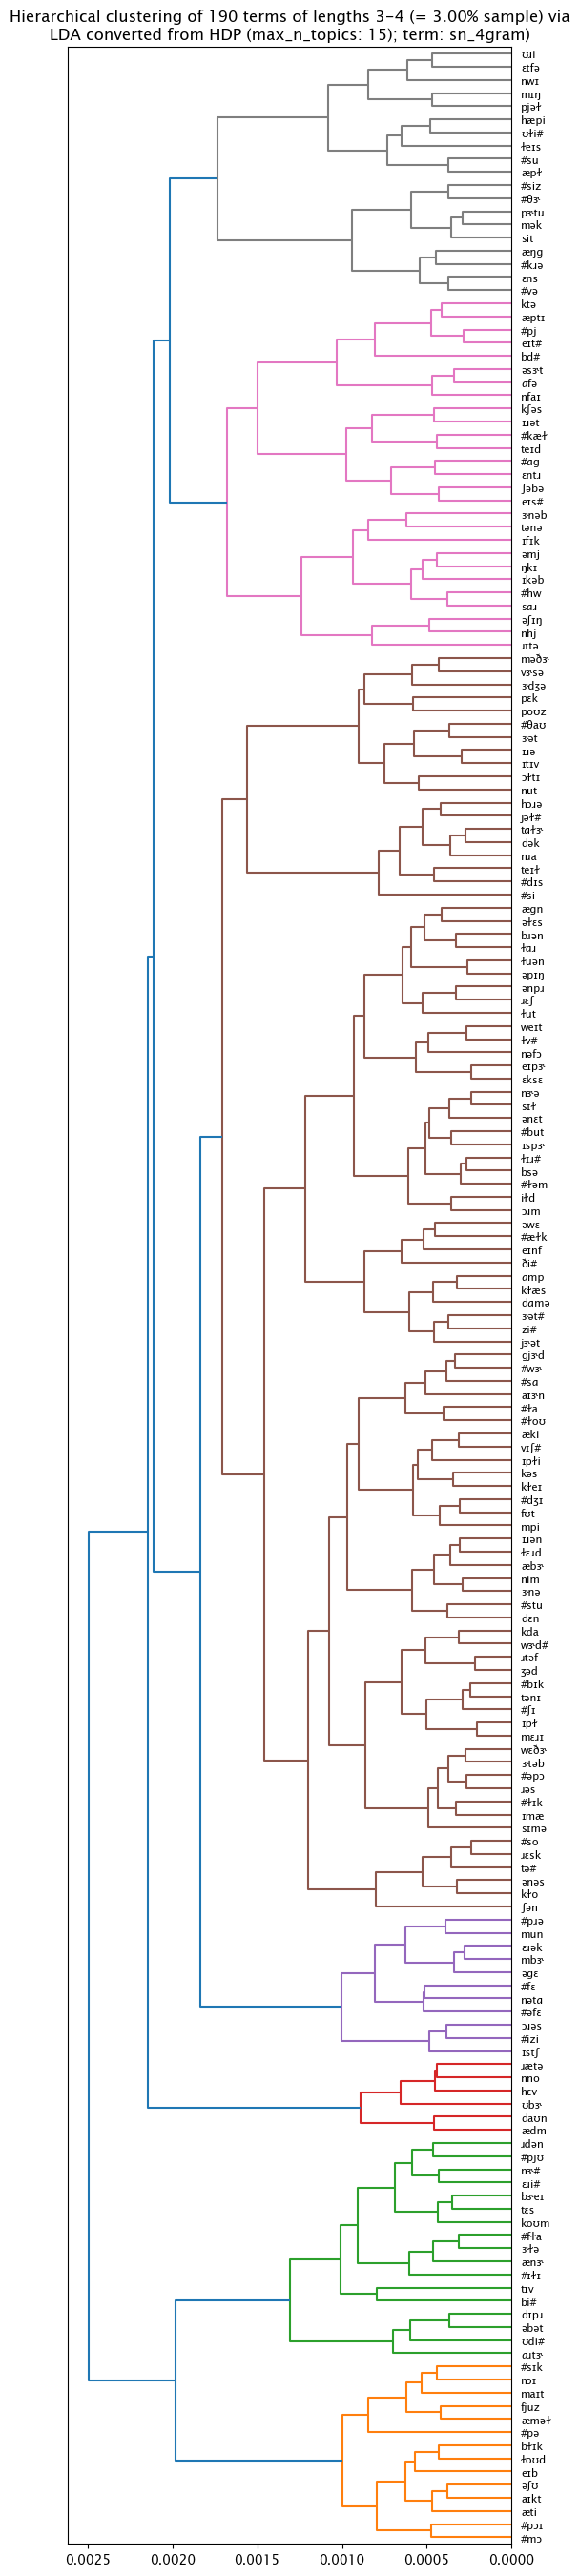

In [735]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp15, diction, n_topics= 15, lowest_density = 0.001, gap_mark = gap_mark, min_length = 3, sampling_rate = 0.03, use_CJK = False, check = False)

In [724]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [725]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [726]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [727]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * ɡətɪ + 0.001 * ənkə + 0.001 * əɡ# + 0.001 * sɝn + 0.001 * #pət + 0.001 * hɑɹ + 0.001 * ti + 0.001 * ɝaʊ + 0.001 * fɹ + 0.001 * skæ + 0.001 * tɝɪ + 0.001 * uɫ# + 0.001 * sɛ + 0.001 * ɛvɝ + 0.001 * bɹɔ + 0.001 * ɪən + 0.001 * ʃætɝ + 0.001 * kɑt + 0.001 * jus + 0.001 * ɪpi
nonzero count: 147
	0.9556: #kætətɑnɪk#
	0.9486: #midieɪt#
	0.9390: #fuɫhɑɹdi#
	0.9390: #dikɹisɪŋ#
	0.9349: #bɪkəmɪŋ#
	0.9249: #əɫɑɹmɪŋ#
	0.9249: #θɝsti#
	0.9249: #sɪtiwaɪd#
	0.9186: #eɪɫɑɹ#
	0.9186: #mɛsi#
	0.9112: #fimeɪɫ#
	0.9112: #speɪd#
	0.9112: #ɹæti#
	0.8779: #snɔti#
	0.8605: #ənɝnd#
topic_id 1: 0.001 * dəb + 0.001 * ɹvd + 0.001 * bɝɪŋ + 0.001 * ɫθi# + 0.001 * vaɪt + 0.001 * zɪŋ# + 0.001 * ɹəfi + 0.001 * ənɪ + 0.001 * #ənb + 0.001 * wɪɫɪ + 0.001 * ɪsɫ + 0.001 * #hæɫ + 0.001 * ɝəbə + 0.001 * mbɪ + 0.001 * umə + 0.001 * aʊɝ# + 0.001 * ɪbd# + 0.001 * ɡɝəs + 0.001 * dip + 0.001 * ɛpt
nonzero count: 145
	0.9577: #ɛnɡeɪdʒɪŋ#
	0.9459: #tɪŋkəɫɪŋ#
	0.9251: #dɹimd#
	0.9251: #pinaɪɫ#
	0.9251: #ɫɑɹvəɫ#
	0

6951 rows remain after density filtering, discarding 13 rows
6951 rows remain after size filtering, discarding 0 rows
209 rows remain after size filtering, discarding 6742 rows


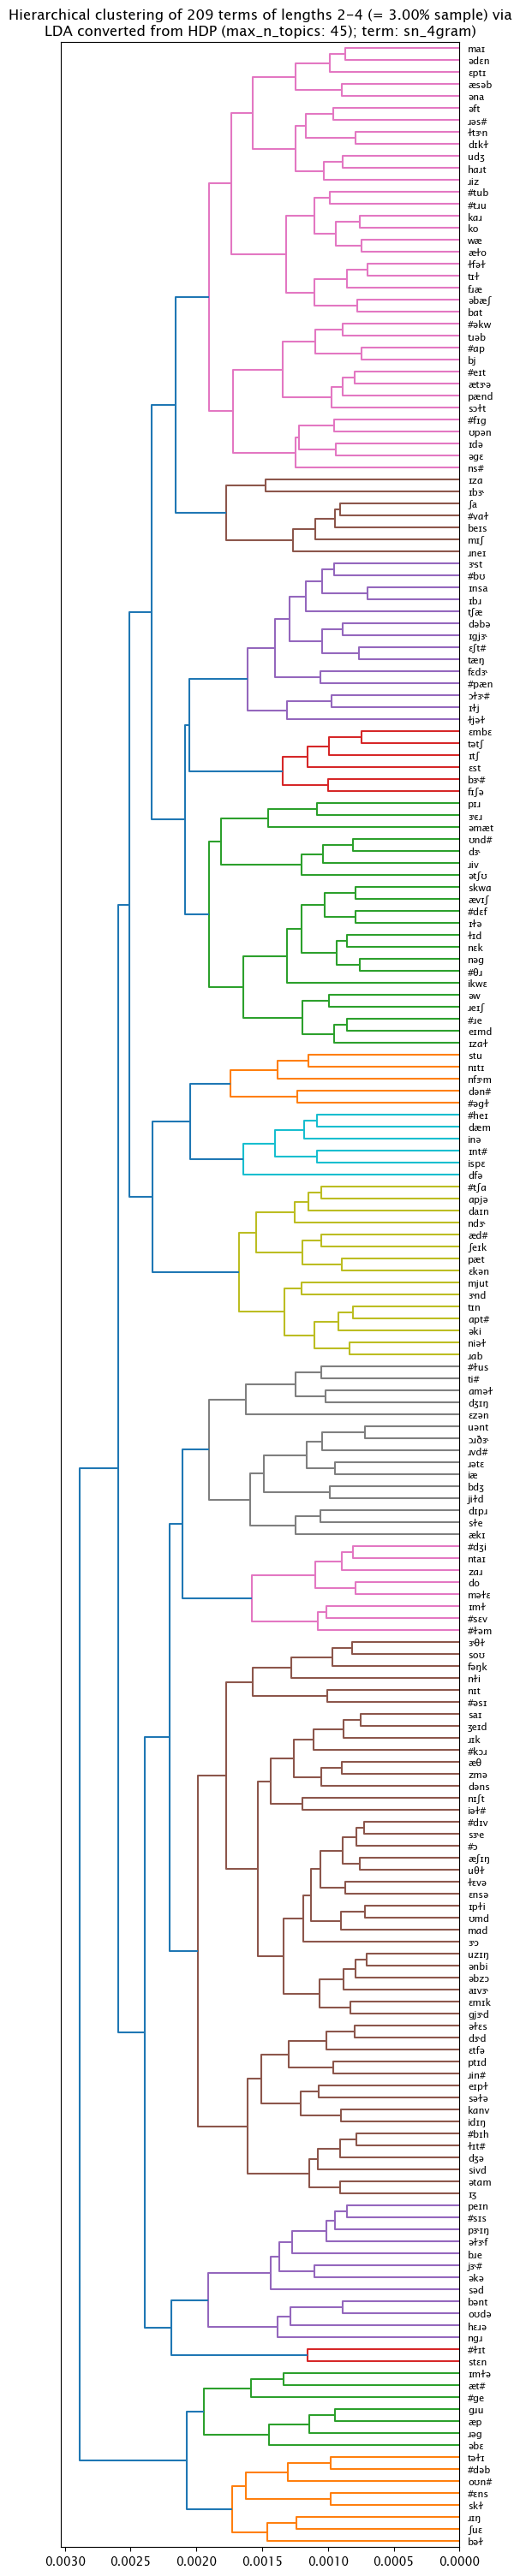

In [737]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp45, diction, n_topics = 45, lowest_density = 0.004, gap_mark = gap_mark, min_length = 2, sampling_rate = 0.03, check = False)

In [729]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [730]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [731]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [732]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * dəb + 0.001 * ɹvd + 0.001 * bɝɪŋ + 0.001 * ɫθi# + 0.001 * vaɪt + 0.001 * zɪŋ# + 0.001 * ɹəfi + 0.001 * ənɪ + 0.001 * #ənb + 0.001 * wɪɫɪ + 0.001 * ɪsɫ + 0.001 * #hæɫ + 0.001 * ɛn + 0.001 * mbɪ + 0.001 * ɝəbə + 0.001 * umə + 0.001 * aʊɝ# + 0.001 * ɪbd# + 0.001 * #ɛn + 0.001 * vəɫ#
nonzero count:  91
	0.9572: #ɛnɡeɪdʒɪŋ#
	0.9482: #ɛnkɝɪdʒɪŋ#
	0.9242: #pinaɪɫ#
	0.9179: #bɫoʊi#
	0.9015: #dɹoʊɫ#
	0.9015: #snæpi#
	0.9015: #bədɪŋ#
	0.8906: #ɛnθ#
	0.8906: #doʊi#
	0.8244: #ɛneɪbəɫɪŋ#
	0.7181: #bəbəɫɪŋ#
	0.7139: #sɑɫvəbəɫ#
	0.7124: #fɫɪpənt#
	0.6696: #ɫusəd#
	0.6603: #ɡeɪbəɫd#
topic_id 1: 0.002 * ɔŋ + 0.001 * ɫɛd + 0.001 * ɑɫə + 0.001 * aɪd + 0.001 * fɛk + 0.001 * #ɹ + 0.001 * ɫik + 0.001 * ɪtɝd + 0.001 * ʊnɪŋ + 0.001 * mpɹɛ + 0.001 * ɑɹʃə + 0.001 * ɫɪ + 0.001 * #nɪ + 0.001 * ɫə# + 0.001 * ɪsɝ + 0.001 * ɫəmɛ + 0.001 * tɹəf + 0.001 * kɹɛd + 0.001 * #kəp + 0.001 * tɝɪŋ
nonzero count:  113
	0.9530: #pəɫɪtəkəɫ#
	0.9420: #ənkɫɪɹ#
	0.9420: #ənsɪvəɫ#
	0.9383: #ɪkwɪvəkəɫ#
	0.9383: #b

6964 rows remain after density filtering, discarding 0 rows
6964 rows remain after size filtering, discarding 0 rows
209 rows remain after size filtering, discarding 6755 rows


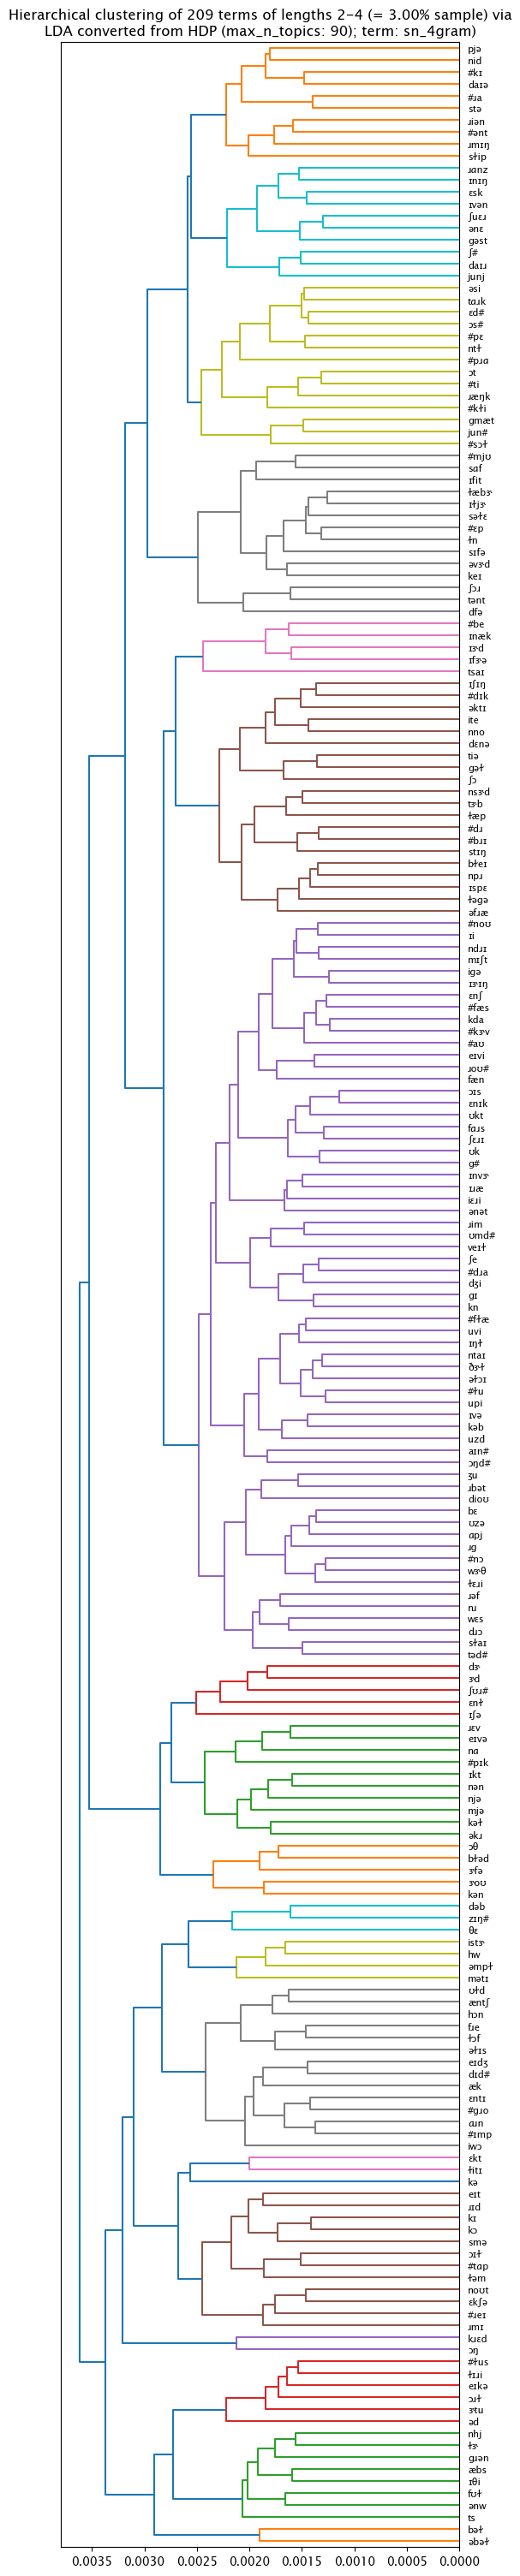

In [736]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp90, diction, n_topics = 90, gap_mark = gap_mark, lowest_density = 0.005, min_length = 2, sampling_rate = 0.03, check = False)